In [26]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


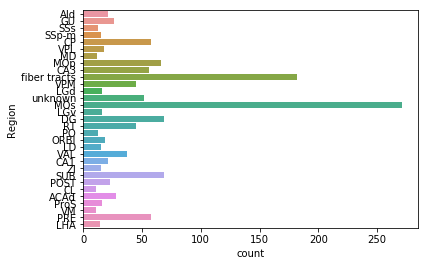

In [27]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )

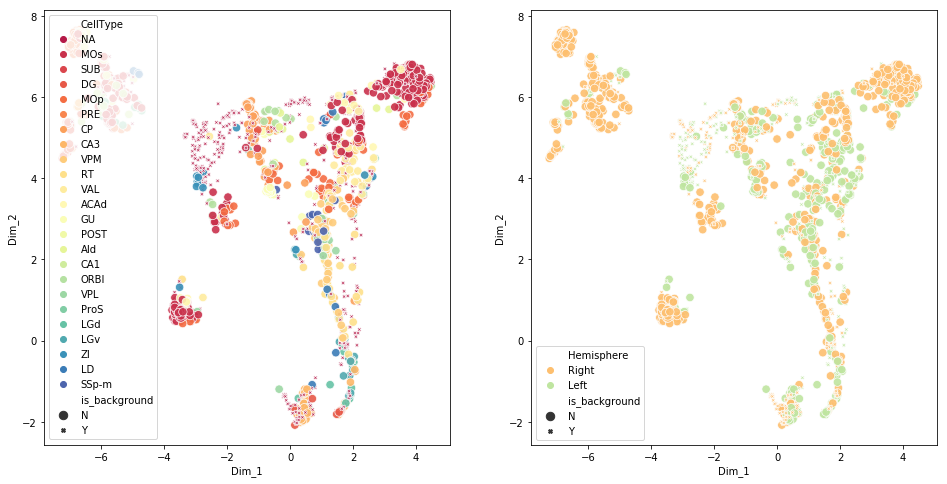

In [28]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)
_ = ns.FeatureScatter(["CellType", "Hemisphere"], map="UMAP")

### Speed of parallel
* for an array testA = nmt.annotation.array[55:90,120:167,179:231].copy()
    * There are 85540 points inside
    * Takes 29.143057346343994 second to run the code.
* For the original array
    * There are 77045760 points inside
    * It may take about 7.25 hours to store all the point. We will try that this evening.

In [29]:
x_block = [range(nmt.annotation.array.shape[0])[i:i + 30] for i in range(0, nmt.annotation.array.shape[0], 30)]
y_block = [range(nmt.annotation.array.shape[1])[i:i + 30] for i in range(0, nmt.annotation.array.shape[1], 30)]
z_block = [range(nmt.annotation.array.shape[2])[i:i + 30] for i in range(0, nmt.annotation.array.shape[2], 30)]

In [30]:
import multiprocessing
import time
def Contour_block6(Temp_arr,x_lower,x_upper,y_lower,y_upper,z_lower,z_upper):#,x_s,y_s,z_s):
    mask_Temp = np.zeros((Temp_arr.shape)) 
    mask_Temp[x_lower:x_upper,y_lower:y_upper,z_lower:z_upper]=1
    
    co_1,co_2,co_3 = np.where(np.multiply(mask_Temp,Temp_arr)!=0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        x2yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        xy1z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xy2z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xyz1 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        xyz2 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        
       
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2]):
            block_list.append([x_in,y_in,z_in])
    return (block_list)



start = time.perf_counter ()
start=time.time()


result_list=[]   
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            temp_array = nmt.annotation.array.copy()
            x_l = iter_X[0]
            x_u = iter_X[-1]+1
            y_l = iter_Y[0]
            y_u = iter_Y[-1]+1
            z_l = iter_Z[0]
            z_u = iter_Z[-1]+1

            result_list.append(Contour_block6(temp_array,x_l,x_u,y_l,y_u,z_l,z_u))#,iter_X[0],iter_Y[0],iter_Z[0]))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))


result_final =  [x for x in result_list if len(x)>0]

Contour_M = nmt.annotation.array.copy()
Contour_M[:,:,:] = 0
start = time.perf_counter ()
start=time.time()
for i in result_final:
    start_sub = time.time()
    for detail_i in i:
        Contour_M[detail_i]=3
    elapsed_sub = time.time()-start_sub
    print('Time needed to generate that block is '+ str(elapsed_sub ))
elapsed = (time.time() - start)
print('Time needed to generate the contour matrix from idx is '+ str(elapsed))

region_ori, count_ori = np.unique(nmt.annotation.array, return_counts=True)
region_contour, count_contour = np.unique(np.multiply(Contour_M==3,nmt.annotation.array), return_counts=True)
print('The brain has '+ str(len(region_ori)) +' regions, after extracting, '+ str(len(region_contour)) +' regions have been detected')

pickle.dump([Contour_M], open("/home/penglab/NMTcode/contour_M_6.pickle", "wb"))

X range: 0:30; Y range: 0:30; Z range: 0:30
X range: 0:30; Y range: 0:30; Z range: 30:60
X range: 0:30; Y range: 0:30; Z range: 60:90
X range: 0:30; Y range: 0:30; Z range: 90:120
X range: 0:30; Y range: 0:30; Z range: 120:150
X range: 0:30; Y range: 0:30; Z range: 150:180
X range: 0:30; Y range: 0:30; Z range: 180:210
X range: 0:30; Y range: 0:30; Z range: 210:240
X range: 0:30; Y range: 0:30; Z range: 240:270
X range: 0:30; Y range: 0:30; Z range: 270:300
X range: 0:30; Y range: 0:30; Z range: 300:330
X range: 0:30; Y range: 0:30; Z range: 330:360
X range: 0:30; Y range: 0:30; Z range: 360:390
X range: 0:30; Y range: 0:30; Z range: 390:420
X range: 0:30; Y range: 0:30; Z range: 420:450
X range: 0:30; Y range: 0:30; Z range: 450:456
X range: 0:30; Y range: 30:60; Z range: 0:30
X range: 0:30; Y range: 30:60; Z range: 30:60
X range: 0:30; Y range: 30:60; Z range: 60:90
X range: 0:30; Y range: 30:60; Z range: 90:120
X range: 0:30; Y range: 30:60; Z range: 120:150
X range: 0:30; Y range: 

X range: 0:30; Y range: 300:320; Z range: 270:300
X range: 0:30; Y range: 300:320; Z range: 300:330
X range: 0:30; Y range: 300:320; Z range: 330:360
X range: 0:30; Y range: 300:320; Z range: 360:390
X range: 0:30; Y range: 300:320; Z range: 390:420
X range: 0:30; Y range: 300:320; Z range: 420:450
X range: 0:30; Y range: 300:320; Z range: 450:456
X range: 30:60; Y range: 0:30; Z range: 0:30
X range: 30:60; Y range: 0:30; Z range: 30:60
X range: 30:60; Y range: 0:30; Z range: 60:90
X range: 30:60; Y range: 0:30; Z range: 90:120
X range: 30:60; Y range: 0:30; Z range: 120:150
X range: 30:60; Y range: 0:30; Z range: 150:180
X range: 30:60; Y range: 0:30; Z range: 180:210
X range: 30:60; Y range: 0:30; Z range: 210:240
X range: 30:60; Y range: 0:30; Z range: 240:270
X range: 30:60; Y range: 0:30; Z range: 270:300
X range: 30:60; Y range: 0:30; Z range: 300:330
X range: 30:60; Y range: 0:30; Z range: 330:360
X range: 30:60; Y range: 0:30; Z range: 360:390
X range: 30:60; Y range: 0:30; Z r

X range: 30:60; Y range: 270:300; Z range: 420:450
X range: 30:60; Y range: 270:300; Z range: 450:456
X range: 30:60; Y range: 300:320; Z range: 0:30
X range: 30:60; Y range: 300:320; Z range: 30:60
X range: 30:60; Y range: 300:320; Z range: 60:90
X range: 30:60; Y range: 300:320; Z range: 90:120
X range: 30:60; Y range: 300:320; Z range: 120:150
X range: 30:60; Y range: 300:320; Z range: 150:180
X range: 30:60; Y range: 300:320; Z range: 180:210
X range: 30:60; Y range: 300:320; Z range: 210:240
X range: 30:60; Y range: 300:320; Z range: 240:270
X range: 30:60; Y range: 300:320; Z range: 270:300
X range: 30:60; Y range: 300:320; Z range: 300:330
X range: 30:60; Y range: 300:320; Z range: 330:360
X range: 30:60; Y range: 300:320; Z range: 360:390
X range: 30:60; Y range: 300:320; Z range: 390:420
X range: 30:60; Y range: 300:320; Z range: 420:450
X range: 30:60; Y range: 300:320; Z range: 450:456
X range: 60:90; Y range: 0:30; Z range: 0:30
X range: 60:90; Y range: 0:30; Z range: 30:60

X range: 60:90; Y range: 270:300; Z range: 90:120
X range: 60:90; Y range: 270:300; Z range: 120:150
X range: 60:90; Y range: 270:300; Z range: 150:180
X range: 60:90; Y range: 270:300; Z range: 180:210
X range: 60:90; Y range: 270:300; Z range: 210:240
X range: 60:90; Y range: 270:300; Z range: 240:270
X range: 60:90; Y range: 270:300; Z range: 270:300
X range: 60:90; Y range: 270:300; Z range: 300:330
X range: 60:90; Y range: 270:300; Z range: 330:360
X range: 60:90; Y range: 270:300; Z range: 360:390
X range: 60:90; Y range: 270:300; Z range: 390:420
X range: 60:90; Y range: 270:300; Z range: 420:450
X range: 60:90; Y range: 270:300; Z range: 450:456
X range: 60:90; Y range: 300:320; Z range: 0:30
X range: 60:90; Y range: 300:320; Z range: 30:60
X range: 60:90; Y range: 300:320; Z range: 60:90
X range: 60:90; Y range: 300:320; Z range: 90:120
X range: 60:90; Y range: 300:320; Z range: 120:150
X range: 60:90; Y range: 300:320; Z range: 150:180
X range: 60:90; Y range: 300:320; Z rang

X range: 90:120; Y range: 240:270; Z range: 180:210
X range: 90:120; Y range: 240:270; Z range: 210:240
X range: 90:120; Y range: 240:270; Z range: 240:270
X range: 90:120; Y range: 240:270; Z range: 270:300
X range: 90:120; Y range: 240:270; Z range: 300:330
X range: 90:120; Y range: 240:270; Z range: 330:360
X range: 90:120; Y range: 240:270; Z range: 360:390
X range: 90:120; Y range: 240:270; Z range: 390:420
X range: 90:120; Y range: 240:270; Z range: 420:450
X range: 90:120; Y range: 240:270; Z range: 450:456
X range: 90:120; Y range: 270:300; Z range: 0:30
X range: 90:120; Y range: 270:300; Z range: 30:60
X range: 90:120; Y range: 270:300; Z range: 60:90
X range: 90:120; Y range: 270:300; Z range: 90:120
X range: 90:120; Y range: 270:300; Z range: 120:150
X range: 90:120; Y range: 270:300; Z range: 150:180
X range: 90:120; Y range: 270:300; Z range: 180:210
X range: 90:120; Y range: 270:300; Z range: 210:240
X range: 90:120; Y range: 270:300; Z range: 240:270
X range: 90:120; Y r

X range: 120:150; Y range: 210:240; Z range: 180:210
X range: 120:150; Y range: 210:240; Z range: 210:240
X range: 120:150; Y range: 210:240; Z range: 240:270
X range: 120:150; Y range: 210:240; Z range: 270:300
X range: 120:150; Y range: 210:240; Z range: 300:330
X range: 120:150; Y range: 210:240; Z range: 330:360
X range: 120:150; Y range: 210:240; Z range: 360:390
X range: 120:150; Y range: 210:240; Z range: 390:420
X range: 120:150; Y range: 210:240; Z range: 420:450
X range: 120:150; Y range: 210:240; Z range: 450:456
X range: 120:150; Y range: 240:270; Z range: 0:30
X range: 120:150; Y range: 240:270; Z range: 30:60
X range: 120:150; Y range: 240:270; Z range: 60:90
X range: 120:150; Y range: 240:270; Z range: 90:120
X range: 120:150; Y range: 240:270; Z range: 120:150
X range: 120:150; Y range: 240:270; Z range: 150:180
X range: 120:150; Y range: 240:270; Z range: 180:210
X range: 120:150; Y range: 240:270; Z range: 210:240
X range: 120:150; Y range: 240:270; Z range: 240:270
X

X range: 150:180; Y range: 180:210; Z range: 150:180
X range: 150:180; Y range: 180:210; Z range: 180:210
X range: 150:180; Y range: 180:210; Z range: 210:240
X range: 150:180; Y range: 180:210; Z range: 240:270
X range: 150:180; Y range: 180:210; Z range: 270:300
X range: 150:180; Y range: 180:210; Z range: 300:330
X range: 150:180; Y range: 180:210; Z range: 330:360
X range: 150:180; Y range: 180:210; Z range: 360:390
X range: 150:180; Y range: 180:210; Z range: 390:420
X range: 150:180; Y range: 180:210; Z range: 420:450
X range: 150:180; Y range: 180:210; Z range: 450:456
X range: 150:180; Y range: 210:240; Z range: 0:30
X range: 150:180; Y range: 210:240; Z range: 30:60
X range: 150:180; Y range: 210:240; Z range: 60:90
X range: 150:180; Y range: 210:240; Z range: 90:120
X range: 150:180; Y range: 210:240; Z range: 120:150
X range: 150:180; Y range: 210:240; Z range: 150:180
X range: 150:180; Y range: 210:240; Z range: 180:210
X range: 150:180; Y range: 210:240; Z range: 210:240
X

X range: 180:210; Y range: 150:180; Z range: 120:150
X range: 180:210; Y range: 150:180; Z range: 150:180
X range: 180:210; Y range: 150:180; Z range: 180:210
X range: 180:210; Y range: 150:180; Z range: 210:240
X range: 180:210; Y range: 150:180; Z range: 240:270
X range: 180:210; Y range: 150:180; Z range: 270:300
X range: 180:210; Y range: 150:180; Z range: 300:330
X range: 180:210; Y range: 150:180; Z range: 330:360
X range: 180:210; Y range: 150:180; Z range: 360:390
X range: 180:210; Y range: 150:180; Z range: 390:420
X range: 180:210; Y range: 150:180; Z range: 420:450
X range: 180:210; Y range: 150:180; Z range: 450:456
X range: 180:210; Y range: 180:210; Z range: 0:30
X range: 180:210; Y range: 180:210; Z range: 30:60
X range: 180:210; Y range: 180:210; Z range: 60:90
X range: 180:210; Y range: 180:210; Z range: 90:120
X range: 180:210; Y range: 180:210; Z range: 120:150
X range: 180:210; Y range: 180:210; Z range: 150:180
X range: 180:210; Y range: 180:210; Z range: 180:210
X

X range: 210:240; Y range: 120:150; Z range: 90:120
X range: 210:240; Y range: 120:150; Z range: 120:150
X range: 210:240; Y range: 120:150; Z range: 150:180
X range: 210:240; Y range: 120:150; Z range: 180:210
X range: 210:240; Y range: 120:150; Z range: 210:240
X range: 210:240; Y range: 120:150; Z range: 240:270
X range: 210:240; Y range: 120:150; Z range: 270:300
X range: 210:240; Y range: 120:150; Z range: 300:330
X range: 210:240; Y range: 120:150; Z range: 330:360
X range: 210:240; Y range: 120:150; Z range: 360:390
X range: 210:240; Y range: 120:150; Z range: 390:420
X range: 210:240; Y range: 120:150; Z range: 420:450
X range: 210:240; Y range: 120:150; Z range: 450:456
X range: 210:240; Y range: 150:180; Z range: 0:30
X range: 210:240; Y range: 150:180; Z range: 30:60
X range: 210:240; Y range: 150:180; Z range: 60:90
X range: 210:240; Y range: 150:180; Z range: 90:120
X range: 210:240; Y range: 150:180; Z range: 120:150
X range: 210:240; Y range: 150:180; Z range: 150:180
X 

X range: 240:270; Y range: 90:120; Z range: 60:90
X range: 240:270; Y range: 90:120; Z range: 90:120
X range: 240:270; Y range: 90:120; Z range: 120:150
X range: 240:270; Y range: 90:120; Z range: 150:180
X range: 240:270; Y range: 90:120; Z range: 180:210
X range: 240:270; Y range: 90:120; Z range: 210:240
X range: 240:270; Y range: 90:120; Z range: 240:270
X range: 240:270; Y range: 90:120; Z range: 270:300
X range: 240:270; Y range: 90:120; Z range: 300:330
X range: 240:270; Y range: 90:120; Z range: 330:360
X range: 240:270; Y range: 90:120; Z range: 360:390
X range: 240:270; Y range: 90:120; Z range: 390:420
X range: 240:270; Y range: 90:120; Z range: 420:450
X range: 240:270; Y range: 90:120; Z range: 450:456
X range: 240:270; Y range: 120:150; Z range: 0:30
X range: 240:270; Y range: 120:150; Z range: 30:60
X range: 240:270; Y range: 120:150; Z range: 60:90
X range: 240:270; Y range: 120:150; Z range: 90:120
X range: 240:270; Y range: 120:150; Z range: 120:150
X range: 240:270; 

X range: 270:300; Y range: 60:90; Z range: 0:30
X range: 270:300; Y range: 60:90; Z range: 30:60
X range: 270:300; Y range: 60:90; Z range: 60:90
X range: 270:300; Y range: 60:90; Z range: 90:120
X range: 270:300; Y range: 60:90; Z range: 120:150
X range: 270:300; Y range: 60:90; Z range: 150:180
X range: 270:300; Y range: 60:90; Z range: 180:210
X range: 270:300; Y range: 60:90; Z range: 210:240
X range: 270:300; Y range: 60:90; Z range: 240:270
X range: 270:300; Y range: 60:90; Z range: 270:300
X range: 270:300; Y range: 60:90; Z range: 300:330
X range: 270:300; Y range: 60:90; Z range: 330:360
X range: 270:300; Y range: 60:90; Z range: 360:390
X range: 270:300; Y range: 60:90; Z range: 390:420
X range: 270:300; Y range: 60:90; Z range: 420:450
X range: 270:300; Y range: 60:90; Z range: 450:456
X range: 270:300; Y range: 90:120; Z range: 0:30
X range: 270:300; Y range: 90:120; Z range: 30:60
X range: 270:300; Y range: 90:120; Z range: 60:90
X range: 270:300; Y range: 90:120; Z range:

X range: 300:330; Y range: 0:30; Z range: 420:450
X range: 300:330; Y range: 0:30; Z range: 450:456
X range: 300:330; Y range: 30:60; Z range: 0:30
X range: 300:330; Y range: 30:60; Z range: 30:60
X range: 300:330; Y range: 30:60; Z range: 60:90
X range: 300:330; Y range: 30:60; Z range: 90:120
X range: 300:330; Y range: 30:60; Z range: 120:150
X range: 300:330; Y range: 30:60; Z range: 150:180
X range: 300:330; Y range: 30:60; Z range: 180:210
X range: 300:330; Y range: 30:60; Z range: 210:240
X range: 300:330; Y range: 30:60; Z range: 240:270
X range: 300:330; Y range: 30:60; Z range: 270:300
X range: 300:330; Y range: 30:60; Z range: 300:330
X range: 300:330; Y range: 30:60; Z range: 330:360
X range: 300:330; Y range: 30:60; Z range: 360:390
X range: 300:330; Y range: 30:60; Z range: 390:420
X range: 300:330; Y range: 30:60; Z range: 420:450
X range: 300:330; Y range: 30:60; Z range: 450:456
X range: 300:330; Y range: 60:90; Z range: 0:30
X range: 300:330; Y range: 60:90; Z range: 3

X range: 300:330; Y range: 300:320; Z range: 360:390
X range: 300:330; Y range: 300:320; Z range: 390:420
X range: 300:330; Y range: 300:320; Z range: 420:450
X range: 300:330; Y range: 300:320; Z range: 450:456
X range: 330:360; Y range: 0:30; Z range: 0:30
X range: 330:360; Y range: 0:30; Z range: 30:60
X range: 330:360; Y range: 0:30; Z range: 60:90
X range: 330:360; Y range: 0:30; Z range: 90:120
X range: 330:360; Y range: 0:30; Z range: 120:150
X range: 330:360; Y range: 0:30; Z range: 150:180
X range: 330:360; Y range: 0:30; Z range: 180:210
X range: 330:360; Y range: 0:30; Z range: 210:240
X range: 330:360; Y range: 0:30; Z range: 240:270
X range: 330:360; Y range: 0:30; Z range: 270:300
X range: 330:360; Y range: 0:30; Z range: 300:330
X range: 330:360; Y range: 0:30; Z range: 330:360
X range: 330:360; Y range: 0:30; Z range: 360:390
X range: 330:360; Y range: 0:30; Z range: 390:420
X range: 330:360; Y range: 0:30; Z range: 420:450
X range: 330:360; Y range: 0:30; Z range: 450:

X range: 330:360; Y range: 270:300; Z range: 330:360
X range: 330:360; Y range: 270:300; Z range: 360:390
X range: 330:360; Y range: 270:300; Z range: 390:420
X range: 330:360; Y range: 270:300; Z range: 420:450
X range: 330:360; Y range: 270:300; Z range: 450:456
X range: 330:360; Y range: 300:320; Z range: 0:30
X range: 330:360; Y range: 300:320; Z range: 30:60
X range: 330:360; Y range: 300:320; Z range: 60:90
X range: 330:360; Y range: 300:320; Z range: 90:120
X range: 330:360; Y range: 300:320; Z range: 120:150
X range: 330:360; Y range: 300:320; Z range: 150:180
X range: 330:360; Y range: 300:320; Z range: 180:210
X range: 330:360; Y range: 300:320; Z range: 210:240
X range: 330:360; Y range: 300:320; Z range: 240:270
X range: 330:360; Y range: 300:320; Z range: 270:300
X range: 330:360; Y range: 300:320; Z range: 300:330
X range: 330:360; Y range: 300:320; Z range: 330:360
X range: 330:360; Y range: 300:320; Z range: 360:390
X range: 330:360; Y range: 300:320; Z range: 390:420
X

X range: 360:390; Y range: 240:270; Z range: 300:330
X range: 360:390; Y range: 240:270; Z range: 330:360
X range: 360:390; Y range: 240:270; Z range: 360:390
X range: 360:390; Y range: 240:270; Z range: 390:420
X range: 360:390; Y range: 240:270; Z range: 420:450
X range: 360:390; Y range: 240:270; Z range: 450:456
X range: 360:390; Y range: 270:300; Z range: 0:30
X range: 360:390; Y range: 270:300; Z range: 30:60
X range: 360:390; Y range: 270:300; Z range: 60:90
X range: 360:390; Y range: 270:300; Z range: 90:120
X range: 360:390; Y range: 270:300; Z range: 120:150
X range: 360:390; Y range: 270:300; Z range: 150:180
X range: 360:390; Y range: 270:300; Z range: 180:210
X range: 360:390; Y range: 270:300; Z range: 210:240
X range: 360:390; Y range: 270:300; Z range: 240:270
X range: 360:390; Y range: 270:300; Z range: 270:300
X range: 360:390; Y range: 270:300; Z range: 300:330
X range: 360:390; Y range: 270:300; Z range: 330:360
X range: 360:390; Y range: 270:300; Z range: 360:390
X

X range: 390:420; Y range: 210:240; Z range: 270:300
X range: 390:420; Y range: 210:240; Z range: 300:330
X range: 390:420; Y range: 210:240; Z range: 330:360
X range: 390:420; Y range: 210:240; Z range: 360:390
X range: 390:420; Y range: 210:240; Z range: 390:420
X range: 390:420; Y range: 210:240; Z range: 420:450
X range: 390:420; Y range: 210:240; Z range: 450:456
X range: 390:420; Y range: 240:270; Z range: 0:30
X range: 390:420; Y range: 240:270; Z range: 30:60
X range: 390:420; Y range: 240:270; Z range: 60:90
X range: 390:420; Y range: 240:270; Z range: 90:120
X range: 390:420; Y range: 240:270; Z range: 120:150
X range: 390:420; Y range: 240:270; Z range: 150:180
X range: 390:420; Y range: 240:270; Z range: 180:210
X range: 390:420; Y range: 240:270; Z range: 210:240
X range: 390:420; Y range: 240:270; Z range: 240:270
X range: 390:420; Y range: 240:270; Z range: 270:300
X range: 390:420; Y range: 240:270; Z range: 300:330
X range: 390:420; Y range: 240:270; Z range: 330:360
X

X range: 420:450; Y range: 180:210; Z range: 240:270
X range: 420:450; Y range: 180:210; Z range: 270:300
X range: 420:450; Y range: 180:210; Z range: 300:330
X range: 420:450; Y range: 180:210; Z range: 330:360
X range: 420:450; Y range: 180:210; Z range: 360:390
X range: 420:450; Y range: 180:210; Z range: 390:420
X range: 420:450; Y range: 180:210; Z range: 420:450
X range: 420:450; Y range: 180:210; Z range: 450:456
X range: 420:450; Y range: 210:240; Z range: 0:30
X range: 420:450; Y range: 210:240; Z range: 30:60
X range: 420:450; Y range: 210:240; Z range: 60:90
X range: 420:450; Y range: 210:240; Z range: 90:120
X range: 420:450; Y range: 210:240; Z range: 120:150
X range: 420:450; Y range: 210:240; Z range: 150:180
X range: 420:450; Y range: 210:240; Z range: 180:210
X range: 420:450; Y range: 210:240; Z range: 210:240
X range: 420:450; Y range: 210:240; Z range: 240:270
X range: 420:450; Y range: 210:240; Z range: 270:300
X range: 420:450; Y range: 210:240; Z range: 300:330
X

X range: 450:480; Y range: 150:180; Z range: 210:240
X range: 450:480; Y range: 150:180; Z range: 240:270
X range: 450:480; Y range: 150:180; Z range: 270:300
X range: 450:480; Y range: 150:180; Z range: 300:330
X range: 450:480; Y range: 150:180; Z range: 330:360
X range: 450:480; Y range: 150:180; Z range: 360:390
X range: 450:480; Y range: 150:180; Z range: 390:420
X range: 450:480; Y range: 150:180; Z range: 420:450
X range: 450:480; Y range: 150:180; Z range: 450:456
X range: 450:480; Y range: 180:210; Z range: 0:30
X range: 450:480; Y range: 180:210; Z range: 30:60
X range: 450:480; Y range: 180:210; Z range: 60:90
X range: 450:480; Y range: 180:210; Z range: 90:120
X range: 450:480; Y range: 180:210; Z range: 120:150
X range: 450:480; Y range: 180:210; Z range: 150:180
X range: 450:480; Y range: 180:210; Z range: 180:210
X range: 450:480; Y range: 180:210; Z range: 210:240
X range: 450:480; Y range: 180:210; Z range: 240:270
X range: 450:480; Y range: 180:210; Z range: 270:300
X

X range: 480:510; Y range: 120:150; Z range: 180:210
X range: 480:510; Y range: 120:150; Z range: 210:240
X range: 480:510; Y range: 120:150; Z range: 240:270
X range: 480:510; Y range: 120:150; Z range: 270:300
X range: 480:510; Y range: 120:150; Z range: 300:330
X range: 480:510; Y range: 120:150; Z range: 330:360
X range: 480:510; Y range: 120:150; Z range: 360:390
X range: 480:510; Y range: 120:150; Z range: 390:420
X range: 480:510; Y range: 120:150; Z range: 420:450
X range: 480:510; Y range: 120:150; Z range: 450:456
X range: 480:510; Y range: 150:180; Z range: 0:30
X range: 480:510; Y range: 150:180; Z range: 30:60
X range: 480:510; Y range: 150:180; Z range: 60:90
X range: 480:510; Y range: 150:180; Z range: 90:120
X range: 480:510; Y range: 150:180; Z range: 120:150
X range: 480:510; Y range: 150:180; Z range: 150:180
X range: 480:510; Y range: 150:180; Z range: 180:210
X range: 480:510; Y range: 150:180; Z range: 210:240
X range: 480:510; Y range: 150:180; Z range: 240:270
X

X range: 510:528; Y range: 90:120; Z range: 150:180
X range: 510:528; Y range: 90:120; Z range: 180:210
X range: 510:528; Y range: 90:120; Z range: 210:240
X range: 510:528; Y range: 90:120; Z range: 240:270
X range: 510:528; Y range: 90:120; Z range: 270:300
X range: 510:528; Y range: 90:120; Z range: 300:330
X range: 510:528; Y range: 90:120; Z range: 330:360
X range: 510:528; Y range: 90:120; Z range: 360:390
X range: 510:528; Y range: 90:120; Z range: 390:420
X range: 510:528; Y range: 90:120; Z range: 420:450
X range: 510:528; Y range: 90:120; Z range: 450:456
X range: 510:528; Y range: 120:150; Z range: 0:30
X range: 510:528; Y range: 120:150; Z range: 30:60
X range: 510:528; Y range: 120:150; Z range: 60:90
X range: 510:528; Y range: 120:150; Z range: 90:120
X range: 510:528; Y range: 120:150; Z range: 120:150
X range: 510:528; Y range: 120:150; Z range: 150:180
X range: 510:528; Y range: 120:150; Z range: 180:210
X range: 510:528; Y range: 120:150; Z range: 210:240
X range: 510

In [37]:
import multiprocessing
import time
def Contour_block18(Temp_arr,x_lower,x_upper,y_lower,y_upper,z_lower,z_upper):#,x_s,y_s,z_s):
    mask_Temp = np.zeros((Temp_arr.shape)) 
    mask_Temp[x_lower:x_upper,y_lower:y_upper,z_lower:z_upper]=1
    co_1,co_2,co_3 = np.where(np.multiply(mask_Temp,Temp_arr)!=0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        x2yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        xy1z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xy2z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xyz1 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        xyz2 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        
       
        x1y1z = Temp_arr[max(0,x_in-1),max(0,y_in-1),z_in]    
        x1y2z = Temp_arr[max(0,x_in-1),min(Temp_arr.shape[1]-1,y_in+1),z_in]    
        x2y1z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),max(0,y_in-1),z_in]    
        x2y2z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),min(Temp_arr.shape[1]-1,y_in+1),z_in]   
        
        xy1z1 = Temp_arr[x_in,max(0,y_in-1),max(0,z_in-1)]                    
        xy2z1 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),max(0,z_in-1)]  
        xy1z2 = Temp_arr[x_in,max(0,y_in-1),min(Temp_arr.shape[2]-1,z_in+1)]                    
        xy2z2 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),min(Temp_arr.shape[2]-1,z_in+1)]  
        
        x1yz1 = Temp_arr[max(0,x_in-1),y_in,max(0,z_in-1)]                    
        x1yz2 = Temp_arr[max(0,x_in-1),y_in,min(Temp_arr.shape[2]-1,z_in+1)]  
        x2yz1 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,max(0,z_in-1)]                    
        x2yz2 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,min(Temp_arr.shape[2]-1,z_in+1)] 
        
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2,x1y1z,x1y2z,x2y1z,x2y2z,xy1z1,xy2z1,
                                          xy1z2,xy2z2,x1yz1,x1yz2,x2yz1,x2yz2]):
            block_list.append([x_in,y_in,z_in])
    return (block_list)


start = time.perf_counter ()
start=time.time()


result_list=[]   
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            temp_array = nmt.annotation.array.copy()
            x_l = iter_X[0]
            x_u = iter_X[-1]+1
            y_l = iter_Y[0]
            y_u = iter_Y[-1]+1
            z_l = iter_Z[0]
            z_u = iter_Z[-1]+1

            result_list.append(Contour_block6(temp_array,x_l,x_u,y_l,y_u,z_l,z_u))#,iter_X[0],iter_Y[0],iter_Z[0]))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))


result_final =  [x for x in result_list if len(x)>0]

Contour_M = nmt.annotation.array.copy()
Contour_M[:,:,:] = 0
start = time.perf_counter ()
start=time.time()
for i in result_final:
    start_sub = time.time()
    for detail_i in i:
        Contour_M[detail_i]= 3
    elapsed_sub = time.time()-start_sub
    print('Time needed to generate that block is '+ str(elapsed_sub ))
elapsed = (time.time() - start)
print('Time needed to generate the contour matrix from idx is '+ str(elapsed))

region_ori, count_ori = np.unique(nmt.annotation.array, return_counts=True)
region_contour, count_contour = np.unique(np.multiply(Contour_M== 3,nmt.annotation.array), return_counts=True)
print('The brain has '+ str(len(region_ori)) +' regions, after extracting, '+ str(len(region_contour)) +' regions have been detected')

pickle.dump([Contour_M], open("/home/penglab/NMTcode/contour_M_18.pickle", "wb"))

X range: 0:30; Y range: 0:30; Z range: 0:30
X range: 0:30; Y range: 0:30; Z range: 30:60
X range: 0:30; Y range: 0:30; Z range: 60:90
X range: 0:30; Y range: 0:30; Z range: 90:120
X range: 0:30; Y range: 0:30; Z range: 120:150
X range: 0:30; Y range: 0:30; Z range: 150:180
X range: 0:30; Y range: 0:30; Z range: 180:210
X range: 0:30; Y range: 0:30; Z range: 210:240
X range: 0:30; Y range: 0:30; Z range: 240:270
X range: 0:30; Y range: 0:30; Z range: 270:300
X range: 0:30; Y range: 0:30; Z range: 300:330
X range: 0:30; Y range: 0:30; Z range: 330:360
X range: 0:30; Y range: 0:30; Z range: 360:390
X range: 0:30; Y range: 0:30; Z range: 390:420
X range: 0:30; Y range: 0:30; Z range: 420:450
X range: 0:30; Y range: 0:30; Z range: 450:456
X range: 0:30; Y range: 30:60; Z range: 0:30
X range: 0:30; Y range: 30:60; Z range: 30:60
X range: 0:30; Y range: 30:60; Z range: 60:90
X range: 0:30; Y range: 30:60; Z range: 90:120
X range: 0:30; Y range: 30:60; Z range: 120:150
X range: 0:30; Y range: 

X range: 0:30; Y range: 300:320; Z range: 270:300
X range: 0:30; Y range: 300:320; Z range: 300:330
X range: 0:30; Y range: 300:320; Z range: 330:360
X range: 0:30; Y range: 300:320; Z range: 360:390
X range: 0:30; Y range: 300:320; Z range: 390:420
X range: 0:30; Y range: 300:320; Z range: 420:450
X range: 0:30; Y range: 300:320; Z range: 450:456
X range: 30:60; Y range: 0:30; Z range: 0:30
X range: 30:60; Y range: 0:30; Z range: 30:60
X range: 30:60; Y range: 0:30; Z range: 60:90
X range: 30:60; Y range: 0:30; Z range: 90:120
X range: 30:60; Y range: 0:30; Z range: 120:150
X range: 30:60; Y range: 0:30; Z range: 150:180
X range: 30:60; Y range: 0:30; Z range: 180:210
X range: 30:60; Y range: 0:30; Z range: 210:240
X range: 30:60; Y range: 0:30; Z range: 240:270
X range: 30:60; Y range: 0:30; Z range: 270:300
X range: 30:60; Y range: 0:30; Z range: 300:330
X range: 30:60; Y range: 0:30; Z range: 330:360
X range: 30:60; Y range: 0:30; Z range: 360:390
X range: 30:60; Y range: 0:30; Z r

X range: 30:60; Y range: 270:300; Z range: 420:450
X range: 30:60; Y range: 270:300; Z range: 450:456
X range: 30:60; Y range: 300:320; Z range: 0:30
X range: 30:60; Y range: 300:320; Z range: 30:60
X range: 30:60; Y range: 300:320; Z range: 60:90
X range: 30:60; Y range: 300:320; Z range: 90:120
X range: 30:60; Y range: 300:320; Z range: 120:150
X range: 30:60; Y range: 300:320; Z range: 150:180
X range: 30:60; Y range: 300:320; Z range: 180:210
X range: 30:60; Y range: 300:320; Z range: 210:240
X range: 30:60; Y range: 300:320; Z range: 240:270
X range: 30:60; Y range: 300:320; Z range: 270:300
X range: 30:60; Y range: 300:320; Z range: 300:330
X range: 30:60; Y range: 300:320; Z range: 330:360
X range: 30:60; Y range: 300:320; Z range: 360:390
X range: 30:60; Y range: 300:320; Z range: 390:420
X range: 30:60; Y range: 300:320; Z range: 420:450
X range: 30:60; Y range: 300:320; Z range: 450:456
X range: 60:90; Y range: 0:30; Z range: 0:30
X range: 60:90; Y range: 0:30; Z range: 30:60

X range: 60:90; Y range: 270:300; Z range: 90:120
X range: 60:90; Y range: 270:300; Z range: 120:150
X range: 60:90; Y range: 270:300; Z range: 150:180
X range: 60:90; Y range: 270:300; Z range: 180:210
X range: 60:90; Y range: 270:300; Z range: 210:240
X range: 60:90; Y range: 270:300; Z range: 240:270
X range: 60:90; Y range: 270:300; Z range: 270:300
X range: 60:90; Y range: 270:300; Z range: 300:330
X range: 60:90; Y range: 270:300; Z range: 330:360
X range: 60:90; Y range: 270:300; Z range: 360:390
X range: 60:90; Y range: 270:300; Z range: 390:420
X range: 60:90; Y range: 270:300; Z range: 420:450
X range: 60:90; Y range: 270:300; Z range: 450:456
X range: 60:90; Y range: 300:320; Z range: 0:30
X range: 60:90; Y range: 300:320; Z range: 30:60
X range: 60:90; Y range: 300:320; Z range: 60:90
X range: 60:90; Y range: 300:320; Z range: 90:120
X range: 60:90; Y range: 300:320; Z range: 120:150
X range: 60:90; Y range: 300:320; Z range: 150:180
X range: 60:90; Y range: 300:320; Z rang

X range: 90:120; Y range: 240:270; Z range: 180:210
X range: 90:120; Y range: 240:270; Z range: 210:240
X range: 90:120; Y range: 240:270; Z range: 240:270
X range: 90:120; Y range: 240:270; Z range: 270:300
X range: 90:120; Y range: 240:270; Z range: 300:330
X range: 90:120; Y range: 240:270; Z range: 330:360
X range: 90:120; Y range: 240:270; Z range: 360:390
X range: 90:120; Y range: 240:270; Z range: 390:420
X range: 90:120; Y range: 240:270; Z range: 420:450
X range: 90:120; Y range: 240:270; Z range: 450:456
X range: 90:120; Y range: 270:300; Z range: 0:30
X range: 90:120; Y range: 270:300; Z range: 30:60
X range: 90:120; Y range: 270:300; Z range: 60:90
X range: 90:120; Y range: 270:300; Z range: 90:120
X range: 90:120; Y range: 270:300; Z range: 120:150
X range: 90:120; Y range: 270:300; Z range: 150:180
X range: 90:120; Y range: 270:300; Z range: 180:210
X range: 90:120; Y range: 270:300; Z range: 210:240
X range: 90:120; Y range: 270:300; Z range: 240:270
X range: 90:120; Y r

X range: 120:150; Y range: 210:240; Z range: 180:210
X range: 120:150; Y range: 210:240; Z range: 210:240
X range: 120:150; Y range: 210:240; Z range: 240:270
X range: 120:150; Y range: 210:240; Z range: 270:300
X range: 120:150; Y range: 210:240; Z range: 300:330
X range: 120:150; Y range: 210:240; Z range: 330:360
X range: 120:150; Y range: 210:240; Z range: 360:390
X range: 120:150; Y range: 210:240; Z range: 390:420
X range: 120:150; Y range: 210:240; Z range: 420:450
X range: 120:150; Y range: 210:240; Z range: 450:456
X range: 120:150; Y range: 240:270; Z range: 0:30
X range: 120:150; Y range: 240:270; Z range: 30:60
X range: 120:150; Y range: 240:270; Z range: 60:90
X range: 120:150; Y range: 240:270; Z range: 90:120
X range: 120:150; Y range: 240:270; Z range: 120:150
X range: 120:150; Y range: 240:270; Z range: 150:180
X range: 120:150; Y range: 240:270; Z range: 180:210
X range: 120:150; Y range: 240:270; Z range: 210:240
X range: 120:150; Y range: 240:270; Z range: 240:270
X

X range: 150:180; Y range: 180:210; Z range: 150:180
X range: 150:180; Y range: 180:210; Z range: 180:210
X range: 150:180; Y range: 180:210; Z range: 210:240
X range: 150:180; Y range: 180:210; Z range: 240:270
X range: 150:180; Y range: 180:210; Z range: 270:300
X range: 150:180; Y range: 180:210; Z range: 300:330
X range: 150:180; Y range: 180:210; Z range: 330:360
X range: 150:180; Y range: 180:210; Z range: 360:390
X range: 150:180; Y range: 180:210; Z range: 390:420
X range: 150:180; Y range: 180:210; Z range: 420:450
X range: 150:180; Y range: 180:210; Z range: 450:456
X range: 150:180; Y range: 210:240; Z range: 0:30
X range: 150:180; Y range: 210:240; Z range: 30:60
X range: 150:180; Y range: 210:240; Z range: 60:90
X range: 150:180; Y range: 210:240; Z range: 90:120
X range: 150:180; Y range: 210:240; Z range: 120:150
X range: 150:180; Y range: 210:240; Z range: 150:180
X range: 150:180; Y range: 210:240; Z range: 180:210
X range: 150:180; Y range: 210:240; Z range: 210:240
X

X range: 180:210; Y range: 150:180; Z range: 120:150
X range: 180:210; Y range: 150:180; Z range: 150:180
X range: 180:210; Y range: 150:180; Z range: 180:210
X range: 180:210; Y range: 150:180; Z range: 210:240
X range: 180:210; Y range: 150:180; Z range: 240:270
X range: 180:210; Y range: 150:180; Z range: 270:300
X range: 180:210; Y range: 150:180; Z range: 300:330
X range: 180:210; Y range: 150:180; Z range: 330:360
X range: 180:210; Y range: 150:180; Z range: 360:390
X range: 180:210; Y range: 150:180; Z range: 390:420
X range: 180:210; Y range: 150:180; Z range: 420:450
X range: 180:210; Y range: 150:180; Z range: 450:456
X range: 180:210; Y range: 180:210; Z range: 0:30
X range: 180:210; Y range: 180:210; Z range: 30:60
X range: 180:210; Y range: 180:210; Z range: 60:90
X range: 180:210; Y range: 180:210; Z range: 90:120
X range: 180:210; Y range: 180:210; Z range: 120:150
X range: 180:210; Y range: 180:210; Z range: 150:180
X range: 180:210; Y range: 180:210; Z range: 180:210
X

X range: 210:240; Y range: 120:150; Z range: 90:120
X range: 210:240; Y range: 120:150; Z range: 120:150
X range: 210:240; Y range: 120:150; Z range: 150:180
X range: 210:240; Y range: 120:150; Z range: 180:210
X range: 210:240; Y range: 120:150; Z range: 210:240
X range: 210:240; Y range: 120:150; Z range: 240:270
X range: 210:240; Y range: 120:150; Z range: 270:300
X range: 210:240; Y range: 120:150; Z range: 300:330
X range: 210:240; Y range: 120:150; Z range: 330:360
X range: 210:240; Y range: 120:150; Z range: 360:390
X range: 210:240; Y range: 120:150; Z range: 390:420
X range: 210:240; Y range: 120:150; Z range: 420:450
X range: 210:240; Y range: 120:150; Z range: 450:456
X range: 210:240; Y range: 150:180; Z range: 0:30
X range: 210:240; Y range: 150:180; Z range: 30:60
X range: 210:240; Y range: 150:180; Z range: 60:90
X range: 210:240; Y range: 150:180; Z range: 90:120
X range: 210:240; Y range: 150:180; Z range: 120:150
X range: 210:240; Y range: 150:180; Z range: 150:180
X 

X range: 240:270; Y range: 90:120; Z range: 60:90
X range: 240:270; Y range: 90:120; Z range: 90:120
X range: 240:270; Y range: 90:120; Z range: 120:150
X range: 240:270; Y range: 90:120; Z range: 150:180
X range: 240:270; Y range: 90:120; Z range: 180:210
X range: 240:270; Y range: 90:120; Z range: 210:240
X range: 240:270; Y range: 90:120; Z range: 240:270
X range: 240:270; Y range: 90:120; Z range: 270:300
X range: 240:270; Y range: 90:120; Z range: 300:330
X range: 240:270; Y range: 90:120; Z range: 330:360
X range: 240:270; Y range: 90:120; Z range: 360:390
X range: 240:270; Y range: 90:120; Z range: 390:420
X range: 240:270; Y range: 90:120; Z range: 420:450
X range: 240:270; Y range: 90:120; Z range: 450:456
X range: 240:270; Y range: 120:150; Z range: 0:30
X range: 240:270; Y range: 120:150; Z range: 30:60
X range: 240:270; Y range: 120:150; Z range: 60:90
X range: 240:270; Y range: 120:150; Z range: 90:120
X range: 240:270; Y range: 120:150; Z range: 120:150
X range: 240:270; 

X range: 270:300; Y range: 60:90; Z range: 0:30
X range: 270:300; Y range: 60:90; Z range: 30:60
X range: 270:300; Y range: 60:90; Z range: 60:90
X range: 270:300; Y range: 60:90; Z range: 90:120
X range: 270:300; Y range: 60:90; Z range: 120:150
X range: 270:300; Y range: 60:90; Z range: 150:180
X range: 270:300; Y range: 60:90; Z range: 180:210
X range: 270:300; Y range: 60:90; Z range: 210:240
X range: 270:300; Y range: 60:90; Z range: 240:270
X range: 270:300; Y range: 60:90; Z range: 270:300
X range: 270:300; Y range: 60:90; Z range: 300:330
X range: 270:300; Y range: 60:90; Z range: 330:360
X range: 270:300; Y range: 60:90; Z range: 360:390
X range: 270:300; Y range: 60:90; Z range: 390:420
X range: 270:300; Y range: 60:90; Z range: 420:450
X range: 270:300; Y range: 60:90; Z range: 450:456
X range: 270:300; Y range: 90:120; Z range: 0:30
X range: 270:300; Y range: 90:120; Z range: 30:60
X range: 270:300; Y range: 90:120; Z range: 60:90
X range: 270:300; Y range: 90:120; Z range:

X range: 300:330; Y range: 0:30; Z range: 420:450
X range: 300:330; Y range: 0:30; Z range: 450:456
X range: 300:330; Y range: 30:60; Z range: 0:30
X range: 300:330; Y range: 30:60; Z range: 30:60
X range: 300:330; Y range: 30:60; Z range: 60:90
X range: 300:330; Y range: 30:60; Z range: 90:120
X range: 300:330; Y range: 30:60; Z range: 120:150
X range: 300:330; Y range: 30:60; Z range: 150:180
X range: 300:330; Y range: 30:60; Z range: 180:210
X range: 300:330; Y range: 30:60; Z range: 210:240
X range: 300:330; Y range: 30:60; Z range: 240:270
X range: 300:330; Y range: 30:60; Z range: 270:300
X range: 300:330; Y range: 30:60; Z range: 300:330
X range: 300:330; Y range: 30:60; Z range: 330:360
X range: 300:330; Y range: 30:60; Z range: 360:390
X range: 300:330; Y range: 30:60; Z range: 390:420
X range: 300:330; Y range: 30:60; Z range: 420:450
X range: 300:330; Y range: 30:60; Z range: 450:456
X range: 300:330; Y range: 60:90; Z range: 0:30
X range: 300:330; Y range: 60:90; Z range: 3

X range: 300:330; Y range: 300:320; Z range: 360:390
X range: 300:330; Y range: 300:320; Z range: 390:420
X range: 300:330; Y range: 300:320; Z range: 420:450
X range: 300:330; Y range: 300:320; Z range: 450:456
X range: 330:360; Y range: 0:30; Z range: 0:30
X range: 330:360; Y range: 0:30; Z range: 30:60
X range: 330:360; Y range: 0:30; Z range: 60:90
X range: 330:360; Y range: 0:30; Z range: 90:120
X range: 330:360; Y range: 0:30; Z range: 120:150
X range: 330:360; Y range: 0:30; Z range: 150:180
X range: 330:360; Y range: 0:30; Z range: 180:210
X range: 330:360; Y range: 0:30; Z range: 210:240
X range: 330:360; Y range: 0:30; Z range: 240:270
X range: 330:360; Y range: 0:30; Z range: 270:300
X range: 330:360; Y range: 0:30; Z range: 300:330
X range: 330:360; Y range: 0:30; Z range: 330:360
X range: 330:360; Y range: 0:30; Z range: 360:390
X range: 330:360; Y range: 0:30; Z range: 390:420
X range: 330:360; Y range: 0:30; Z range: 420:450
X range: 330:360; Y range: 0:30; Z range: 450:

X range: 330:360; Y range: 270:300; Z range: 330:360
X range: 330:360; Y range: 270:300; Z range: 360:390
X range: 330:360; Y range: 270:300; Z range: 390:420
X range: 330:360; Y range: 270:300; Z range: 420:450
X range: 330:360; Y range: 270:300; Z range: 450:456
X range: 330:360; Y range: 300:320; Z range: 0:30
X range: 330:360; Y range: 300:320; Z range: 30:60
X range: 330:360; Y range: 300:320; Z range: 60:90
X range: 330:360; Y range: 300:320; Z range: 90:120
X range: 330:360; Y range: 300:320; Z range: 120:150
X range: 330:360; Y range: 300:320; Z range: 150:180
X range: 330:360; Y range: 300:320; Z range: 180:210
X range: 330:360; Y range: 300:320; Z range: 210:240
X range: 330:360; Y range: 300:320; Z range: 240:270
X range: 330:360; Y range: 300:320; Z range: 270:300
X range: 330:360; Y range: 300:320; Z range: 300:330
X range: 330:360; Y range: 300:320; Z range: 330:360
X range: 330:360; Y range: 300:320; Z range: 360:390
X range: 330:360; Y range: 300:320; Z range: 390:420
X

X range: 360:390; Y range: 240:270; Z range: 300:330
X range: 360:390; Y range: 240:270; Z range: 330:360
X range: 360:390; Y range: 240:270; Z range: 360:390
X range: 360:390; Y range: 240:270; Z range: 390:420
X range: 360:390; Y range: 240:270; Z range: 420:450
X range: 360:390; Y range: 240:270; Z range: 450:456
X range: 360:390; Y range: 270:300; Z range: 0:30
X range: 360:390; Y range: 270:300; Z range: 30:60
X range: 360:390; Y range: 270:300; Z range: 60:90
X range: 360:390; Y range: 270:300; Z range: 90:120
X range: 360:390; Y range: 270:300; Z range: 120:150
X range: 360:390; Y range: 270:300; Z range: 150:180
X range: 360:390; Y range: 270:300; Z range: 180:210
X range: 360:390; Y range: 270:300; Z range: 210:240
X range: 360:390; Y range: 270:300; Z range: 240:270
X range: 360:390; Y range: 270:300; Z range: 270:300
X range: 360:390; Y range: 270:300; Z range: 300:330
X range: 360:390; Y range: 270:300; Z range: 330:360
X range: 360:390; Y range: 270:300; Z range: 360:390
X

X range: 390:420; Y range: 210:240; Z range: 270:300
X range: 390:420; Y range: 210:240; Z range: 300:330
X range: 390:420; Y range: 210:240; Z range: 330:360
X range: 390:420; Y range: 210:240; Z range: 360:390
X range: 390:420; Y range: 210:240; Z range: 390:420
X range: 390:420; Y range: 210:240; Z range: 420:450
X range: 390:420; Y range: 210:240; Z range: 450:456
X range: 390:420; Y range: 240:270; Z range: 0:30
X range: 390:420; Y range: 240:270; Z range: 30:60
X range: 390:420; Y range: 240:270; Z range: 60:90
X range: 390:420; Y range: 240:270; Z range: 90:120
X range: 390:420; Y range: 240:270; Z range: 120:150
X range: 390:420; Y range: 240:270; Z range: 150:180
X range: 390:420; Y range: 240:270; Z range: 180:210
X range: 390:420; Y range: 240:270; Z range: 210:240
X range: 390:420; Y range: 240:270; Z range: 240:270
X range: 390:420; Y range: 240:270; Z range: 270:300
X range: 390:420; Y range: 240:270; Z range: 300:330
X range: 390:420; Y range: 240:270; Z range: 330:360
X

X range: 420:450; Y range: 180:210; Z range: 240:270
X range: 420:450; Y range: 180:210; Z range: 270:300
X range: 420:450; Y range: 180:210; Z range: 300:330
X range: 420:450; Y range: 180:210; Z range: 330:360
X range: 420:450; Y range: 180:210; Z range: 360:390
X range: 420:450; Y range: 180:210; Z range: 390:420
X range: 420:450; Y range: 180:210; Z range: 420:450
X range: 420:450; Y range: 180:210; Z range: 450:456
X range: 420:450; Y range: 210:240; Z range: 0:30
X range: 420:450; Y range: 210:240; Z range: 30:60
X range: 420:450; Y range: 210:240; Z range: 60:90
X range: 420:450; Y range: 210:240; Z range: 90:120
X range: 420:450; Y range: 210:240; Z range: 120:150
X range: 420:450; Y range: 210:240; Z range: 150:180
X range: 420:450; Y range: 210:240; Z range: 180:210
X range: 420:450; Y range: 210:240; Z range: 210:240
X range: 420:450; Y range: 210:240; Z range: 240:270
X range: 420:450; Y range: 210:240; Z range: 270:300
X range: 420:450; Y range: 210:240; Z range: 300:330
X

X range: 450:480; Y range: 150:180; Z range: 210:240
X range: 450:480; Y range: 150:180; Z range: 240:270
X range: 450:480; Y range: 150:180; Z range: 270:300
X range: 450:480; Y range: 150:180; Z range: 300:330
X range: 450:480; Y range: 150:180; Z range: 330:360
X range: 450:480; Y range: 150:180; Z range: 360:390
X range: 450:480; Y range: 150:180; Z range: 390:420
X range: 450:480; Y range: 150:180; Z range: 420:450
X range: 450:480; Y range: 150:180; Z range: 450:456
X range: 450:480; Y range: 180:210; Z range: 0:30
X range: 450:480; Y range: 180:210; Z range: 30:60
X range: 450:480; Y range: 180:210; Z range: 60:90
X range: 450:480; Y range: 180:210; Z range: 90:120
X range: 450:480; Y range: 180:210; Z range: 120:150
X range: 450:480; Y range: 180:210; Z range: 150:180
X range: 450:480; Y range: 180:210; Z range: 180:210
X range: 450:480; Y range: 180:210; Z range: 210:240
X range: 450:480; Y range: 180:210; Z range: 240:270
X range: 450:480; Y range: 180:210; Z range: 270:300
X

X range: 480:510; Y range: 120:150; Z range: 180:210
X range: 480:510; Y range: 120:150; Z range: 210:240
X range: 480:510; Y range: 120:150; Z range: 240:270
X range: 480:510; Y range: 120:150; Z range: 270:300
X range: 480:510; Y range: 120:150; Z range: 300:330
X range: 480:510; Y range: 120:150; Z range: 330:360
X range: 480:510; Y range: 120:150; Z range: 360:390
X range: 480:510; Y range: 120:150; Z range: 390:420
X range: 480:510; Y range: 120:150; Z range: 420:450
X range: 480:510; Y range: 120:150; Z range: 450:456
X range: 480:510; Y range: 150:180; Z range: 0:30
X range: 480:510; Y range: 150:180; Z range: 30:60
X range: 480:510; Y range: 150:180; Z range: 60:90
X range: 480:510; Y range: 150:180; Z range: 90:120
X range: 480:510; Y range: 150:180; Z range: 120:150
X range: 480:510; Y range: 150:180; Z range: 150:180
X range: 480:510; Y range: 150:180; Z range: 180:210
X range: 480:510; Y range: 150:180; Z range: 210:240
X range: 480:510; Y range: 150:180; Z range: 240:270
X

X range: 510:528; Y range: 90:120; Z range: 150:180
X range: 510:528; Y range: 90:120; Z range: 180:210
X range: 510:528; Y range: 90:120; Z range: 210:240
X range: 510:528; Y range: 90:120; Z range: 240:270
X range: 510:528; Y range: 90:120; Z range: 270:300
X range: 510:528; Y range: 90:120; Z range: 300:330
X range: 510:528; Y range: 90:120; Z range: 330:360
X range: 510:528; Y range: 90:120; Z range: 360:390
X range: 510:528; Y range: 90:120; Z range: 390:420
X range: 510:528; Y range: 90:120; Z range: 420:450
X range: 510:528; Y range: 90:120; Z range: 450:456
X range: 510:528; Y range: 120:150; Z range: 0:30
X range: 510:528; Y range: 120:150; Z range: 30:60
X range: 510:528; Y range: 120:150; Z range: 60:90
X range: 510:528; Y range: 120:150; Z range: 90:120
X range: 510:528; Y range: 120:150; Z range: 120:150
X range: 510:528; Y range: 120:150; Z range: 150:180
X range: 510:528; Y range: 120:150; Z range: 180:210
X range: 510:528; Y range: 120:150; Z range: 210:240
X range: 510

Time needed to generate that block is 0.2989776134490967
Time needed to generate that block is 0.20630598068237305
Time needed to generate that block is 0.010924100875854492
Time needed to generate that block is 0.003435373306274414
Time needed to generate that block is 0.02005600929260254
Time needed to generate that block is 0.0032453536987304688
Time needed to generate that block is 0.019153356552124023
Time needed to generate that block is 0.00748896598815918
Time needed to generate that block is 0.07370209693908691
Time needed to generate that block is 0.10347390174865723
Time needed to generate that block is 0.20032954216003418
Time needed to generate that block is 0.13041901588439941
Time needed to generate that block is 0.10173249244689941
Time needed to generate that block is 0.06685137748718262
Time needed to generate that block is 0.1453995704650879
Time needed to generate that block is 0.08264827728271484
Time needed to generate that block is 0.546992301940918
Time needed t

Time needed to generate that block is 0.17039060592651367
Time needed to generate that block is 0.021472692489624023
Time needed to generate that block is 0.15035605430603027
Time needed to generate that block is 0.09290623664855957
Time needed to generate that block is 0.0024194717407226562
Time needed to generate that block is 0.03239297866821289
Time needed to generate that block is 0.37701964378356934
Time needed to generate that block is 0.46834897994995117
Time needed to generate that block is 0.4274787902832031
Time needed to generate that block is 0.6793897151947021
Time needed to generate that block is 0.5932211875915527
Time needed to generate that block is 0.4251441955566406
Time needed to generate that block is 0.4587383270263672
Time needed to generate that block is 0.06570124626159668
Time needed to generate that block is 0.011306047439575195
Time needed to generate that block is 0.2875347137451172
Time needed to generate that block is 0.4967775344848633
Time needed to ge

Time needed to generate that block is 0.35182714462280273
Time needed to generate that block is 0.5684535503387451
Time needed to generate that block is 0.6577873229980469
Time needed to generate that block is 0.6743161678314209
Time needed to generate that block is 0.30190300941467285
Time needed to generate that block is 0.5972113609313965
Time needed to generate that block is 0.8007955551147461
Time needed to generate that block is 0.6524271965026855
Time needed to generate that block is 0.007226228713989258
Time needed to generate that block is 0.1329493522644043
Time needed to generate that block is 0.3942699432373047
Time needed to generate that block is 0.4774038791656494
Time needed to generate that block is 0.5331242084503174
Time needed to generate that block is 0.08431148529052734
Time needed to generate that block is 0.6127674579620361
Time needed to generate that block is 0.23572778701782227
Time needed to generate that block is 0.4478156566619873
Time needed to generate t

Time needed to generate that block is 0.24341917037963867
Time needed to generate that block is 0.12122607231140137
Time needed to generate that block is 0.0002980232238769531
Time needed to generate that block is 0.013641595840454102
Time needed to generate that block is 0.12843608856201172
Time needed to generate that block is 0.21447086334228516
Time needed to generate that block is 0.038759469985961914
Time needed to generate that block is 0.19631361961364746
Time needed to generate that block is 0.1583406925201416
Time needed to generate that block is 0.03130674362182617
Time needed to generate that block is 0.011483430862426758
Time needed to generate that block is 0.32891321182250977
Time needed to generate that block is 0.5652234554290771
Time needed to generate that block is 0.614004373550415
Time needed to generate that block is 0.6222825050354004
Time needed to generate that block is 0.77370285987854
Time needed to generate that block is 0.6521081924438477
Time needed to gen

Time needed to generate that block is 0.6735002994537354
Time needed to generate that block is 0.1484379768371582
Time needed to generate that block is 0.09622502326965332
Time needed to generate that block is 0.4419255256652832
Time needed to generate that block is 0.4822728633880615
Time needed to generate that block is 0.8987991809844971
Time needed to generate that block is 1.0193712711334229
Time needed to generate that block is 0.98008131980896
Time needed to generate that block is 1.0964128971099854
Time needed to generate that block is 0.9496817588806152
Time needed to generate that block is 1.0224409103393555
Time needed to generate that block is 1.168344259262085
Time needed to generate that block is 0.5853233337402344
Time needed to generate that block is 0.515214204788208
Time needed to generate that block is 0.1764061450958252
Time needed to generate that block is 0.4231078624725342
Time needed to generate that block is 0.712460994720459
Time needed to generate that block 

Time needed to generate that block is 0.5731933116912842
Time needed to generate that block is 0.3482041358947754
Time needed to generate that block is 0.8505628108978271
Time needed to generate that block is 0.773787260055542
Time needed to generate that block is 0.5842478275299072
Time needed to generate that block is 0.3459188938140869
Time needed to generate that block is 0.011576175689697266
Time needed to generate that block is 0.7293524742126465
Time needed to generate that block is 0.7009882926940918
Time needed to generate that block is 0.9287405014038086
Time needed to generate that block is 0.7309994697570801
Time needed to generate that block is 0.8847379684448242
Time needed to generate that block is 0.9462618827819824
Time needed to generate that block is 1.0802063941955566
Time needed to generate that block is 0.9626774787902832
Time needed to generate that block is 0.8968555927276611
Time needed to generate that block is 0.7434544563293457
Time needed to generate that b

Time needed to generate that block is 1.0259246826171875
Time needed to generate that block is 0.4237558841705322
Time needed to generate that block is 0.9394724369049072
Time needed to generate that block is 1.0067839622497559
Time needed to generate that block is 0.8291642665863037
Time needed to generate that block is 0.935784101486206
Time needed to generate that block is 0.8430948257446289
Time needed to generate that block is 0.9458701610565186
Time needed to generate that block is 1.082603931427002
Time needed to generate that block is 0.44913387298583984
Time needed to generate that block is 1.0036113262176514
Time needed to generate that block is 0.6745824813842773
Time needed to generate that block is 0.16622138023376465
Time needed to generate that block is 0.29867982864379883
Time needed to generate that block is 0.7911596298217773
Time needed to generate that block is 1.106060266494751
Time needed to generate that block is 0.42522621154785156
Time needed to generate that b

Time needed to generate that block is 0.9368882179260254
Time needed to generate that block is 0.14592552185058594
Time needed to generate that block is 0.2282102108001709
Time needed to generate that block is 1.0876855850219727
Time needed to generate that block is 0.4836552143096924
Time needed to generate that block is 0.7847673892974854
Time needed to generate that block is 0.9948618412017822
Time needed to generate that block is 0.69281005859375
Time needed to generate that block is 0.5079259872436523
Time needed to generate that block is 0.5895411968231201
Time needed to generate that block is 0.5339910984039307
Time needed to generate that block is 0.614229679107666
Time needed to generate that block is 1.0574615001678467
Time needed to generate that block is 0.8863630294799805
Time needed to generate that block is 0.2528386116027832
Time needed to generate that block is 1.1972894668579102
Time needed to generate that block is 0.4698038101196289
Time needed to generate that bloc

Time needed to generate that block is 0.9742493629455566
Time needed to generate that block is 1.0480165481567383
Time needed to generate that block is 0.14957499504089355
Time needed to generate that block is 0.013829231262207031
Time needed to generate that block is 0.8341295719146729
Time needed to generate that block is 0.8484368324279785
Time needed to generate that block is 0.76181960105896
Time needed to generate that block is 0.6775050163269043
Time needed to generate that block is 0.42937254905700684
Time needed to generate that block is 0.42023277282714844
Time needed to generate that block is 1.2380859851837158
Time needed to generate that block is 0.5340635776519775
Time needed to generate that block is 0.44612812995910645
Time needed to generate that block is 0.6430706977844238
Time needed to generate that block is 0.7374899387359619
Time needed to generate that block is 0.7886016368865967
Time needed to generate that block is 0.9222116470336914
Time needed to generate tha

Time needed to generate that block is 0.2591094970703125
Time needed to generate that block is 0.7746062278747559
Time needed to generate that block is 0.8924026489257812
Time needed to generate that block is 0.31625938415527344
Time needed to generate that block is 0.7304954528808594
Time needed to generate that block is 0.312788724899292
Time needed to generate that block is 0.7990505695343018
Time needed to generate that block is 0.7388942241668701
Time needed to generate that block is 0.4881319999694824
Time needed to generate that block is 0.1125636100769043
Time needed to generate that block is 0.04328632354736328
Time needed to generate that block is 0.0919334888458252
Time needed to generate that block is 0.6474463939666748
Time needed to generate that block is 0.9106001853942871
Time needed to generate that block is 0.36646270751953125
Time needed to generate that block is 0.861670732498169
Time needed to generate that block is 0.25086212158203125
Time needed to generate that 

Time needed to generate that block is 0.5048267841339111
Time needed to generate that block is 0.4743812084197998
Time needed to generate that block is 0.4258568286895752
Time needed to generate that block is 0.17950224876403809
Time needed to generate that block is 0.015993833541870117
Time needed to generate that block is 0.14236044883728027
Time needed to generate that block is 0.3413846492767334
Time needed to generate that block is 0.634615421295166
Time needed to generate that block is 0.5464482307434082
Time needed to generate that block is 0.5556814670562744
Time needed to generate that block is 0.5168728828430176
Time needed to generate that block is 0.5260727405548096
Time needed to generate that block is 0.5568878650665283
Time needed to generate that block is 0.6474673748016357
Time needed to generate that block is 0.3973679542541504
Time needed to generate that block is 0.19183969497680664
Time needed to generate that block is 0.003275632858276367
Time needed to generate t

Time needed to generate that block is 0.8035881519317627
Time needed to generate that block is 0.8326666355133057
Time needed to generate that block is 1.0289626121520996
Time needed to generate that block is 0.8799207210540771
Time needed to generate that block is 0.22858643531799316
Time needed to generate that block is 0.03580737113952637
Time needed to generate that block is 0.0004596710205078125
Time needed to generate that block is 0.7105860710144043
Time needed to generate that block is 0.4190809726715088
Time needed to generate that block is 0.6335914134979248
Time needed to generate that block is 0.9262139797210693
Time needed to generate that block is 0.731236457824707
Time needed to generate that block is 0.4743843078613281
Time needed to generate that block is 0.6574392318725586
Time needed to generate that block is 0.10127949714660645
Time needed to generate that block is 0.6166605949401855
Time needed to generate that block is 0.6067140102386475
Time needed to generate th

import multiprocessing
import time
def Contour_block6(Temp_arr):#,x_s,y_s,z_s):
    co_1,co_2,co_3 = np.where(Temp_arr != 0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        x2yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        xy1z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xy2z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xyz1 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        xyz2 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        
       
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2]):
            block_list.append([x_in,y_in,z_in])
    return (block_list)



start = time.perf_counter ()
start=time.time()


result_list=[]   
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            temp_array = nmt.annotation.array.copy()
            temp_array[iter_X[0]:iter_X[-1]+1,iter_Y[0]:iter_Y[-1]+1,iter_Z[0]:iter_Z[-1]+1]=1
            temp_array = np.multiply(nmt.annotation.array,temp_array)
            result_list.append(Contour_block18(temp_array))#,iter_X[0],iter_Y[0],iter_Z[0]))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))
#ContourDic['ALL']= ([xx for xx in  result_list])

import multiprocessing
import time
def Contour_block18(Temp_arr):
    co_1,co_2,co_3 = np.where(Temp_arr != 0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        x2yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        xy1z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xy2z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xyz1 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        xyz2 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        
        
        x1y1z = Temp_arr[max(0,x_in-1),max(0,y_in-1),z_in]    
        x1y2z = Temp_arr[max(0,x_in-1),min(Temp_arr.shape[1]-1,y_in+1),z_in]    
        x2y1z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),max(0,y_in-1),z_in]    
        x2y2z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),min(Temp_arr.shape[1]-1,y_in+1),z_in]   
        
        xy1z1 = Temp_arr[x_in,max(0,y_in-1),max(0,z_in-1)]                    
        xy2z1 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),max(0,z_in-1)]  
        xy1z2 = Temp_arr[x_in,max(0,y_in-1),min(Temp_arr.shape[2]-1,z_in+1)]                    
        xy2z2 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),min(Temp_arr.shape[2]-1,z_in+1)]  
        
        x1yz1 = Temp_arr[max(0,x_in-1),y_in,max(0,z_in-1)]                    
        x1yz2 = Temp_arr[max(0,x_in-1),y_in,min(Temp_arr.shape[2]-1,z_in+1)]  
        x2yz1 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,max(0,z_in-1)]                    
        x2yz2 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,min(Temp_arr.shape[2]-1,z_in+1)] 
        
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2,x1y1z,x1y2z,x2y1z,x2y2z,xy1z1,xy2z1,
                                          xy1z2,xy2z2,x1yz1,x1yz2,x2yz1,x2yz2]):
            block_list.append([x_in,y_in,z_in])
    return (block_list)



start = time.perf_counter ()
start=time.time()


result_list=[]   
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            temp_array = nmt.annotation.array[iter_X[0]:iter_X[-1]+1,iter_Y[0]:iter_Y[-1]+1,iter_Z[0]:iter_Z[-1]+1].copy()
            result_list.append(Contour_block18(temp_array))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))
#ContourDic['ALL']= ([xx for xx in  result_list])

result_final =  [x for x in result_list if len(x)>0]

Contour_M = nmt.annotation.array.copy()
Contour_M[:,:,:] = 0
start = time.perf_counter ()
start=time.time()
for i in result_final:
    start_sub = time.time()
    for detail_i in i:
        Contour_M[detail_i]=3
    elapsed_sub = time.time()-start_sub
    print('Time needed to generate that block is '+ str(elapsed_sub ))
elapsed = (time.time() - start)
print('Time needed to generate the contour matrix from idx is '+ str(elapsed))

regionN, count = np.unique(np.multiply(Contour_M==3,nmt.annotation.array), return_counts=True)
regionN

In [ ]:
pickle.dump([Contour_M], open("/home/penglab/NMTcode/contour_M_6.pickle", "wb"))

In [19]:
np.sum(np.multiply(Contour_M==3,nmt.annotation.array==0))

4009369

In [20]:
4009369+368231

4377600

In [17]:
147894+128959+91378

368231

In [10]:
1053648


4377600

In [16]:
regionN, count = np.unique(np.multiply(Contour_M==3,nmt.annotation.array), return_counts=True)

for iterr in range(len(regionN)):
    if regionN[iterr] in [507, 698, 1016]:
        print(regionN[iterr])
        print(count[iterr])
        print('\n')

507
147894


698
128959


1016
91378


